# Simulating metformin infusions

Assumptions:
- Large doses of metformin block (liver) lactate consumption by blocking pyruvate consumption
  effectivly increasing net glucose to lactate flux.

In [1]:
from model import *

import seaborn as sns
import matplotlib.pyplot as plt

# Set the font size
plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})
plt.rcParams.update({'lines.markeredgewidth': 1})


In [2]:
p = reference_parameters(0,0,0
            )


In [3]:
p

[0.15241935483870966,
 0.6,
 1.4,
 0.2777777777777778,
 0.15,
 0.9449999999999998,
 1.0,
 2.0,
 5.0,
 0.034501675056324,
 0.69003350112648,
 10,
 1.0,
 0.0]

In [4]:
import pandas as pd

# Function t

def run_ko_study(replicate = 1, concentration_noise=0.1, flux_noise=0.1, ki_noise=0.1, t_max=240, vE=1.0, m_in=1.0):

    p = reference_parameters(concentration_noise, flux_noise, ki_noise=ki_noise)

    # Scenario 1: Metformin
    #p_met = change_parameters(p, e=[vE], ix=["vE"])
    p_met = change_parameters(p, e=[vE], ix=["vE"], fold_change=True)
    x0 = steady_state(p_met)
    x0 = np.concatenate([x0, [0.0]])
    t, metformin_overdose = response(p_met, t_max=t_max, concentration_noise=concentration_noise, 
                                     type='metformin',metformin_in=m_in, x0=x0)

    # Scenario 2: Metformin + HCAR1 KO
    p_hcar1 = change_parameters(p_met, e=[1e9], ix=["KI_F0_L"], fold_change=True)
    x0 = steady_state(p_hcar1)
    x0 = np.concatenate([x0, [0.0]])
    t, hcar1_ko = response(p_hcar1, t_max=t_max, concentration_noise=concentration_noise, 
                           type='metformin',metformin_in=m_in, x0=x0)

    # Scenario 3: Metformin + HCAR1 agonits
    KI_F0_L = p[parameter_names.index('KI_F0_L')]
    p_hcar1_agonist = change_parameters(p_met, e=[0.1], ix=["KI_F0_L"], fold_change=True)
    x0 = steady_state(p_hcar1_agonist)
    x0 = np.concatenate([x0, [0.0]])
    t, hcar1_agonist = response(p_hcar1_agonist, t_max=t_max, 
                                concentration_noise=concentration_noise, 
                                x0=x0,type='metformin',metformin_in=m_in)

    #Build a dataframe
    df_met = pd.DataFrame(metformin_overdose, columns=['Glucose', 'Lactate', 'Fatty acids', 'Insulin', 'Metformin'] ) 
    df_met['Scenario'] = 'Metformin'
    df_met['time'] = t  

    df_hcar1 = pd.DataFrame(hcar1_ko, columns=['Glucose', 'Lactate', 'Fatty acids', 'Insulin', 'Metformin'] )   
    df_hcar1['Scenario'] = 'Metformin + HCAR1 KO'
    df_hcar1['time'] = t

    df_hcar1_agonist = pd.DataFrame(hcar1_agonist, columns=['Glucose', 'Lactate', 'Fatty acids', 'Insulin', 'Metformin'] )
    df_hcar1_agonist['Scenario'] = 'Metformin + HCAR1 agonist'
    df_hcar1_agonist['time'] = t

    df = pd.concat([df_met, df_hcar1, df_hcar1_agonist])
    df['Replicate'] = replicate 

    return  df
    

In [5]:
# Run the study
n_replicates = 500
concentration_noise = 0.1
flux_noise = 0.0
ki_noise = 0.1

results= [run_ko_study(replicate = i, concentration_noise=concentration_noise, 
                         flux_noise=flux_noise, ki_noise=ki_noise, t_max=240) 
                         for i in range(n_replicates)]

results = pd.concat(results)

# Scale the concentration to mM
results['Glucose'] = results['Glucose']*5.5
results['Lactate'] = results['Lactate']*0.75
results['Fatty acids'] = results['Fatty acids']*0.5
results['Insulin'] = results['Insulin']*insulin(1,1,0)



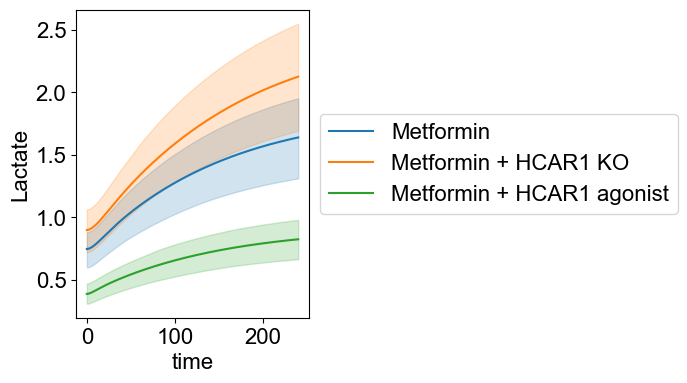

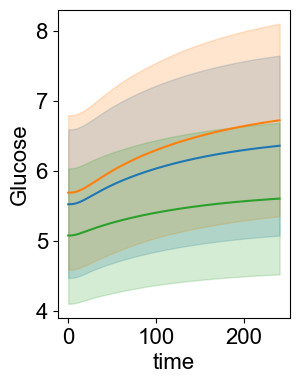

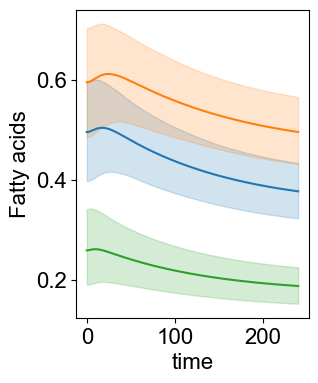

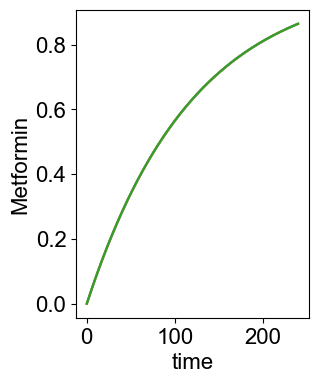

In [6]:
f,ax = plt.subplots(1,1, figsize=(3,4))

sns.lineplot(data=results, x='time', y='Lactate', hue='Scenario', ax=ax, errorbar='pi')
# Legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


f,ax = plt.subplots(1,1, figsize=(3,4))
sns.lineplot(data=results, x='time', y='Glucose', hue='Scenario', ax=ax, errorbar='pi')
# Remove the legend
plt.legend([],[], frameon=False)
plt.show()

f,ax = plt.subplots(1,1, figsize=(3,4))
sns.lineplot(data=results, x='time', y='Fatty acids', hue='Scenario', ax=ax, errorbar='pi')
# Remove the legend
plt.legend([],[], frameon=False)
plt.show()

f,ax = plt.subplots(1,1, figsize=(3,4))
sns.lineplot(data=results, x='time', y='Metformin', hue='Scenario', ax=ax, errorbar='pi')
# Remove the legend
plt.legend([],[], frameon=False)
plt.show()
